In [1]:
# Imports básicos
import numpy as np
from numpy import random
import pandas as pd
import math
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')
random.RandomState(1)

# Imports scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs, make_moons
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# Imports pytroch
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as TF
from PIL import Image as Pil_Image
from google.colab import drive
from torchsummary import summary

# Imports para plots
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

!mkdir -p pasta-covid-mascara-2

!wget -q https://www.dropbox.com/s/jbynu7nn1nabymy/Train2.zip -O pasta-covid-mascara-2/treino.zip
!unzip -o -q pasta-covid-mascara-2/treino.zip -d pasta-covid-mascara-2/

!wget -q https://www.dropbox.com/s/r6xoz38nszc6f5k/Test.zip -O pasta-covid-mascara-2/teste.zip
!unzip -o -q pasta-covid-mascara-2/teste.zip -d pasta-covid-mascara-2/

In [3]:
height = 224
width = 224
input_size = (height,width)


data_transforms = {
  'train' : transforms.Compose([
        #transforms.RandomResizedCrop(input_size),
        transforms.Resize(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),                                            
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                                    
        ]),
  'test'   : transforms.Compose([
        transforms.Resize(input_size),        
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

train_data=datasets.ImageFolder('pasta-covid-mascara-2/Train2', transform=data_transforms['train'])
#val_size = int(len(train_data)*0.5)
train_size = 5000
val_size = 5000
test_size = len(train_data)-train_size-val_size
#len(train_data)-val_size, val_size
train_data, val_data, test_data = torch.utils.data.random_split(train_data, [train_size, val_size, test_size])

#test_data=datasets.ImageFolder('pasta-covid-mascara-2/Test', transform=data_transforms['test'])

In [4]:
batch_size = 16
train_loader = data_utils.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = data_utils.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = data_utils.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [5]:
print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Testing set size:", len(test_data))

Training set size: 5000
Validation set size: 5000
Testing set size: 9544


In [6]:
len(train_data)

5000

In [7]:
train_iter = iter(train_loader)
images, labels = next(train_iter)
print('Shape de images:', images.shape)
print('Shape de labels:', labels.shape)

Shape de images: torch.Size([16, 3, 224, 224])
Shape de labels: torch.Size([16])


In [8]:
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [9]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg16":
        """ VGG11_bn
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "mobilenet_v2":
        """ 
        """
        model_ft = models.mobilenet_v2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name =="mobilenet_v3_small":
        model_ft = models.mobilenet_v2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[3] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name =="mobilenet_v3_large":
        model_ft = models.mobilenet_v2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[3] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [10]:
ef = models.mobilenet_v3_large(pretrained=True)
ef

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False

In [11]:
model_name = 'squeezenet'
num_classes = 2
feature_extract = True
use_pretreined = True

In [12]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained = use_pretreined)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

In [13]:
model_ft.to(device)


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [14]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [15]:
_, y_pred = torch.max(model_ft(images.cuda()),1)

In [16]:
y_pred

tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')

In [17]:
y = labels.cuda()

In [18]:
y_pred

tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')

In [19]:
def train_epoch(model, trainLoader, optimizer, criterion):
    model.train()
    losses = []
    for X, y in trainLoader:    
        X, y = X.to(device), y.to(device)            
        optimizer.zero_grad()
        # (1) Passar os dados pela rede neural (forward)
        output = model(X)                              
        # (2) Calcular o erro da saída da rede com a classe das instâncias (loss)                    
        loss = criterion(output, y)        
        # (3) Usar o erro para calcular quanto cada peso (wi) contribuiu com esse erro (backward)
        loss.backward()
        # (4) Ataulizar os pesos da rede neural
        optimizer.step()        
        losses.append(loss.item())        
    model.eval()
    return np.mean(losses)

def eval_model(model, loader):
    measures = []
    total = 0
    correct = 0
    for X, y in loader:                
        X, y = X.to(device), y.to(device)             
        output = model(X)                      
        _, y_pred = torch.max(output, 1)
        total += len(y)
        correct += (y_pred == y).sum().cpu().data.numpy()
    measures = {'acc' : correct/total}
    return measures

def train_and_evaluate(model, num_epochs, train_loader, test_loader, optimizer, criterion):
  max_val_acc = 0
  e_measures = []
  pbar = tqdm(range(1,num_epochs+1))
  for e in pbar:
      losses =  train_epoch(model, train_loader, optimizer, criterion)
      measures_on_train = eval_model(model, train_loader)
      measures_on_test  = eval_model(model, test_loader )
      train_loss = np.mean(losses)
      measures = {'epoch': e, 'train_loss': train_loss, 'train_acc' : measures_on_train['acc'].round(4), 'val_acc' : measures_on_test['acc'].round(4) }
      if (max_val_acc < measures_on_test['acc'].round(4)):
        
        max_val_acc = measures_on_test['acc'].round(4)
        torch.save(model.state_dict(), 'modelo')

      pbar.set_postfix(measures)     
      e_measures += [measures]
  return pd.DataFrame(e_measures)   

In [20]:
criterion = nn.CrossEntropyLoss()  
# TODO - Definir o número de epocas de treinamento
num_epochs = 1
# TODO - Executar o treinamento da rede neural
train_and_evaluate(model_ft, num_epochs, train_loader, val_loader, optimizer_ft, criterion)  

  0%|          | 0/1 [00:00<?, ?it/s]

,epoch,train_loss,train_acc,val_acc
0,1,0.102362,0.9832,0.9818


In [21]:
# TODO - Criar um dicionário para significado das classes
label_desc = {0 : 'com máscara', 1 : 'sem máscara'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

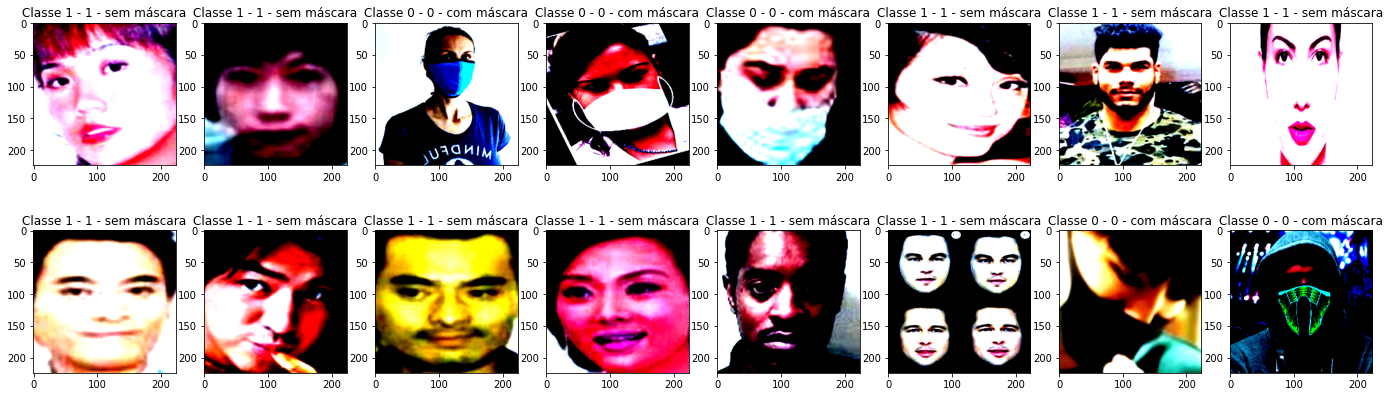

In [22]:
test_iter = iter(test_loader)
images, labels = next(test_iter)

fig = plt.figure(figsize=(24, 7))
rows = 2
columns = math.ceil(batch_size / rows)

output = model_ft(images.to(device))
_, y_pred = torch.max(output, 1)
y_pred = y_pred.cpu().data.numpy()
for i in range(0, columns*rows):    
    img = images[i].permute(1, 2, 0).squeeze()    
    fig.add_subplot(rows, columns, i+1, title = 'Classe %i - %i - %s' % (labels[i], y_pred[i], label_desc[ y_pred[i] ] ) )
    plt.imshow(img)

In [23]:
  torch.save(model_ft, "modelo_mascara_squeezenet.pth")

# **Avaliando com métricas** #

In [24]:
print(y.cpu())
print(y_pred)
print(test_loader)
print(train_iter)

tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0])
[1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0]


In [25]:
def evaluate_model(y_true, y_pred):
    return {
        'acc': accuracy_score(y_true, y_pred), 
        #'confusion_matrix' : confusion_matrix(y_true, y_pred),
        'prec' : precision_score(y_true, y_pred),
        'recall' : recall_score(y_true, y_pred),
        'f1' : f1_score(y_true, y_pred)
    }

In [26]:
h = evaluate_model([0,1,0,1,1,1,0,1,0,0],[0,1,0,1,1,1,0,1,0,1])
h['model_name'] = model_name
pd.DataFrame([h])

,acc,prec,recall,f1,model_name
0,0.9,0.833333,1.0,0.909091,squeezenet


In [27]:
def predict(model, loader):
    y_true = []
    y_pred = []
    
    for X, y in loader:                
        X, y = X.to(device), y.to(device)             
        output = model(X)                      
        _, y_pred_ = torch.max(output, 1)
        for y_ in y.cpu():
          y_true.append(y_)
        for y_ in y_pred_.cpu():
          y_pred.append(y_)
        
    return y_true, y_pred

In [ ]:
model_list = ['alexnet', 'vgg16', 'squeezenet', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small' ]
h_list = []
for model_name in model_list:
  model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained = use_pretreined)
    # Send the model to GPU
  model_ft = model_ft.to(device)

  # Gather the parameters to be optimized/updated in this run. If we are
  #  finetuning we will be updating all parameters. However, if we are
  #  doing feature extract method, we will only update the parameters
  #  that we have just initialized, i.e. the parameters with requires_grad
  #  is True.
  params_to_update = model_ft.parameters()
  print("Params to learn:")
  if feature_extract:
      params_to_update = []
      for name,param in model_ft.named_parameters():
          if param.requires_grad == True:
              params_to_update.append(param)
              print("\t",name)
  else:
      for name,param in model_ft.named_parameters():
          if param.requires_grad == True:
              print("\t",name)

  # Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
  criterion = nn.CrossEntropyLoss()  
  num_epochs = 1
  train_and_evaluate(model_ft, num_epochs, train_loader, val_loader, optimizer_ft, criterion) 
  y_true, y_pred = predict(model_ft, test_loader)
  h = evaluate_model(y_true, y_pred) 
  h['model_name'] = model_name
  h_list.append(h)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


  0%|          | 0/1 [00:00<?, ?it/s]

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


  0%|          | 0/1 [00:00<?, ?it/s]

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


  0%|          | 0/1 [00:00<?, ?it/s]

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


  0%|          | 0/1 [00:00<?, ?it/s]

IndexError: ignored

In [ ]:
l = pd.DataFrame(h_list) 
print(l.to_latex())

In [30]:
alexnet = models.alexnet()
vgg16 = models.vgg16()
squeezenet = models.squeezenet1_0()
mobilenetv2 = models.mobilenet_v2()
mobilenetv3 = models.mobilenet_v3_large()

summary(vgg16, (3, 224, 244))

RuntimeError: ignored

## **Acurácia** #

In [ ]:
#print(accuracy_score(y.cpu(), y_pred))

## **Matriz de confusão** #


In [ ]:
#print(confusion_matrix(y.cpu(), y_pred))

## **Precision score** 

In [ ]:
#print(precision_score(y.cpu(), y_pred))

## **Recall Score** 

In [ ]:
#print(recall_score(y.cpu(), y_pred))